In [1]:
import numpy as np
import gzip
import os

data_dir = "./mnist/"
filenames = ['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']
data = []

for filename in filenames:
    filepath = os.path.join(data_dir, filename)
    print("Loading", filepath)
    with gzip.open(filepath, 'rb') as f:
        if 'labels' in filename:
            data.append(np.frombuffer(f.read(), np.uint8, offset = 8))
        else:
            data.append(np.frombuffer(f.read(), np.uint8, offset = 16).reshape(-1, 28*28))

x_train, y_train, x_test, y_test = data

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

print("Data loaded successfully!")

Loading ./mnist/train-images-idx3-ubyte.gz
Loading ./mnist/train-labels-idx1-ubyte.gz
Loading ./mnist/t10k-images-idx3-ubyte.gz
Loading ./mnist/t10k-labels-idx1-ubyte.gz
Data loaded successfully!


In [2]:
import matplotlib.pyplot as plt
def show_images(images, labels):
    pixels = images.reshape(-1, 28, 28)
    fig, axs = plt.subplots(ncols = len(images), nrows = 1, figsize = (10, 3 * len(images)))

    for i in range(len(images)):
        axs[i].imshow(pixels[i], cmap = 'gray')
        axs[i].set_title(f"Label: {labels[i]}")

        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_xlabel(f"Index: {i}")

    fig.subplots_adjust(hspace = 0.5)
    plt.show()

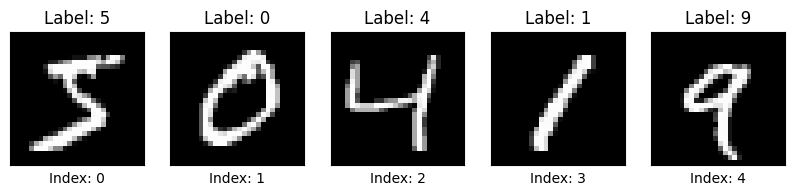

In [3]:
show_images(x_train[:5], y_train[:5])

In [ ]:
import torch.nn as nn
import torch
import torch.optim as optim

class AutoEncoder(nn.Module):
    def __init__(self, num_hidden = 8):
        super().__init__()

        self.num_hidden = num_hidden

        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, self.num_hidden),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.num_hidden, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

learning_rate = 1e-3
batch_size = 64
n_epochs = 5

x_train = torch.from_numpy(x_train)

Using device: cuda


In [16]:
model = AutoEncoder(num_hidden=4)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

model.to(device)

train_loader = torch.utils.data.DataLoader(
    x_train, batch_size = batch_size, shuffle = True
)

In [17]:
num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        encoded, decoded = model(data)

        loss = criterion(decoded, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.size(0)
    
    epoch_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}: loss={round(epoch_loss, 4)}")

Epoch 1/10: loss=0.0601
Epoch 2/10: loss=0.0491
Epoch 3/10: loss=0.0417
Epoch 4/10: loss=0.0395
Epoch 5/10: loss=0.0384
Epoch 6/10: loss=0.0377
Epoch 7/10: loss=0.0371
Epoch 8/10: loss=0.0366
Epoch 9/10: loss=0.0362
Epoch 10/10: loss=0.0359


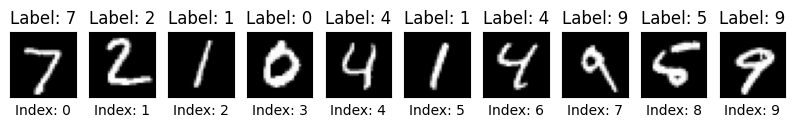

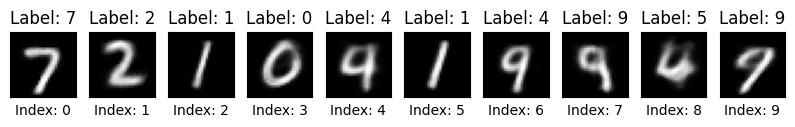

In [18]:
num_samples = 10

test_samples = x_test[:num_samples]
test_samples = torch.tensor(test_samples).to(device)
test_samples = test_samples.view(-1, 784)

model.eval()

with torch.no_grad():
    _, reconstructed = model(test_samples)

test_samples = test_samples.cpu()
reconstructed = reconstructed.cpu()

test_samples = test_samples.numpy().reshape(-1, 28, 28)
reconstructed = reconstructed.numpy().reshape(-1, 28, 28)

show_images(test_samples, y_test[:num_samples])
show_images(reconstructed, y_test[:num_samples])